## Composite Bayesian Optimization with the High Order Gaussian Process

In this tutorial, we're going to explore composite Bayesian optimization [Astudillo & Frazier, ICML, '19](https://proceedings.mlr.press/v97/astudillo19a.html) with the High Order Gaussian Process (HOGP) model of [Zhe et al, AISTATS, '19](http://proceedings.mlr.press/v89/zhe19a.html). The setup for composite Bayesian optimization is that we have an unknown (black box) function mapping input parameters to several outputs, and a second, known function describing the quality of the functional output. We wish to find input parameters that maximize the output metric function. We wish to find input parameters that maximize the output metric function in a black-box manner. 

Specifically, this can be described as $\max_{x \in \mathcal{X}} g(f(x)),$ where $f$ is unknown and $g$ is known. As in traditional Bayesian optimization, we are going to construct a Gaussian process surrogate model over the expensive to evaluate function $f(.),$ and will use a HOGP to model this function. 

### HOGP model description

The [High Order Gaussian Process (HOGP) model](https://proceedings.mlr.press/v89/zhe19a.html) is a Gaussian process model designed specifically to operate over tensors or multi-dimensional arrays and exploits structure in the tensor to be able to operate efficiently. Specifically, the HOGP takes as inputs $y \in \mathbb{R}^{N \times d_2 \times \cdots \times d_M}$ and assumes that $\text{vec}(y) \sim \mathcal{N}(0, \otimes_{i=1}^M K_i + \sigma^2 I),$ where $K_1 = K_{XX}.$ Each dimension of the tensor has its own kernel function, $K_i,$ as well as a set of $d_i$ latent parameters that can be optimized over.

Recently, [Maddox et al, '21](https://arxiv.org/abs/2106.12997) proposed a method for computing posterior samples from the HOGP by exploiting structure in the posterior distribution, thereby enabling its usage in BO settings. While they show that this approach allows to use composite BO on problems with tens or thousands of outputs, for scalability we consider a much smaller example here (that does not require GPU acceleration).

In [5]:
import math
import os
import time
from functools import partial

import gpytorch.settings as gpt_settings
import matplotlib.pyplot as plt
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition.objective import GenericMCObjective
from botorch.models import HigherOrderGP, SingleTaskGP
from botorch.models.higher_order_gp import FlattenedStandardize
from botorch.models.transforms import Normalize, Standardize
from botorch.optim import optimize_acqf
from botorch.optim.fit import fit_gpytorch_mll_torch
from botorch.sampling.normal import IIDNormalSampler
from gpytorch.mlls import ExactMarginalLogLikelihood
from linear_operator.settings import _fast_solves
from torch.optim import Adam

%matplotlib inline

SMOKE_TEST = os.environ.get("SMOKE_TEST")

#### Set Device and dtype

In [6]:
torch.manual_seed(0)
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:4")
)
dtype = torch.float

print("Using ", device)

Using  cpu


In [7]:
models_used = (
    "rnd",
    "ei",
    "ei_hogp_cf",
)

### Problem Description

We use a simple test problem describing the concentration of pollutants after a chemical spill from [Astudillo & Frazier, ICML, '19](https://proceedings.mlr.press/v97/astudillo19a.html) defined over a $3 \times 4$ grid of values $s,t$ and we wish to optimize the parameters w.r.t. their true values, to estimate the true value of parameters, $x = [M, D, L, \tau].$ The function is given by 
$$ f(s,t | M, D, L, \tau) := \frac{M}{\sqrt{4 \pi D t}}  \exp\{-\frac{s^2}{4Dt}\} + \frac{1_{t > \tau} M}{\sqrt{4 \pi D(t - \tau)}} \exp\{- \frac{(s - L)^2}{4 D (t - \tau)}\}, $$
with the cheap to evaluate, differentiable function given by $g(y):= \sum_{(s,t) \in S \times T} \left(c(s, t|x_{\text{true}}) - y\right)^2.$ As the objective function itself is going to be implemented in Pytorch, we will be able to differentiate through it, enabling the usage of gradient-based optimization to optimize the objectives with respect to the inputs.

In [8]:
def env_cfun(s, t, M, D, L, tau):
    c1 = M / torch.sqrt(4 * math.pi * D * t)
    exp1 = torch.exp(-(s**2) / 4 / D / t)
    term1 = c1 * exp1
    c2 = M / torch.sqrt(4 * math.pi * D * (t - tau))
    exp2 = torch.exp(-((s - L) ** 2) / 4 / D / (t - tau))
    term2 = c2 * exp2
    term2[torch.isnan(term2)] = 0.0
    return term1 + term2

#### Helper Functions

These are helper functions for us to maximize the acquisition function and to get random points.

In [9]:
def gen_rand_points(bounds, num_samples):
    points_nlzd = torch.rand(num_samples, bounds.shape[-1]).to(bounds)
    return bounds[0] + (bounds[1] - bounds[0]) * points_nlzd


def optimize_ei(qEI, bounds, **options):
    cands_nlzd, _ = optimize_acqf(qEI, bounds, **options)
    return cands_nlzd

Below is a wrapped function to help us define bounds on the parameter space, we can also vary the size of the grid if we'd like to.

In [10]:
def prepare_data(s_size=3, t_size=4, device=device, dtype=dtype):
    print("---- Running the environmental problem with ", s_size, t_size, " ----")
    # X = [M, D, L, tau]
    bounds = torch.tensor(
        [[7.0, 0.02, 0.01, 30.010], [13.0, 0.12, 3.00, 30.295]],
        device=device,
        dtype=dtype,
    )

    M0 = torch.tensor(10.0, device=device, dtype=dtype)
    D0 = torch.tensor(0.07, device=device, dtype=dtype)
    L0 = torch.tensor(1.505, device=device, dtype=dtype)
    tau0 = torch.tensor(30.1525, device=device, dtype=dtype)

    # we can vectorize everything, no need for loops
    if s_size == 3:
        S = torch.tensor([0.0, 1.0, 2.5], device=device, dtype=dtype)
    else:
        S = torch.linspace(0.0, 2.5, s_size, device=device, dtype=dtype)
    if t_size == 4:
        T = torch.tensor([15.0, 30.0, 45.0, 60.0], device=device, dtype=dtype)
    else:
        T = torch.linspace(15.0, 60.0, t_size, device=device, dtype=dtype)

    Sgrid, Tgrid = torch.meshgrid(S, T)

    # X = [M, D, L, tau]
    def c_batched(X, k=None):
        return torch.stack([env_cfun(Sgrid, Tgrid, *x) for x in X])

    c_true = env_cfun(Sgrid, Tgrid, M0, D0, L0, tau0)

    def neq_sum_quared_diff(samples):
        # unsqueeze
        if samples.shape[-1] == (s_size * t_size):
            samples = samples.unsqueeze(-1).reshape(*samples.shape[:-1], s_size, t_size)

        sq_diffs = (samples - c_true).pow(2)
        return sq_diffs.sum(dim=(-1, -2)).mul(-1.0)

    objective = GenericMCObjective(neq_sum_quared_diff)
    num_samples = 32

    return c_batched, objective, bounds, num_samples

In the above, we construct a `GenericMCObjective` instance to codify the objective function (which is minimizing the MSE of the output tensors and the outputs corresponding to the "true" parameter values). Note that the objective function is encoded in PyTorch and is differentiable (although it technically doesn't have to be). Ultimately, we backpropagate through the objective with respect to the input parameters (and through the HOGP as well).

## BO Loop

Finally, we run the BO loop for 10 iterations, generating 3 candidates in each iteration. This loop might take a while.

We will be comparing to both random selection and batch expected improvement on the aggregated metric.

In [11]:
n_init = 20

if SMOKE_TEST:
    n_batches = 1
    batch_size = 2
else:
    n_batches = 10
    batch_size = 3

As a word of caution, we've found that when fitting the HOGP model, using first-order optimizers (e.g. Adam) as is used in `fit_gpytorch_torch` tends to outperform second-order optimizers such as L-BFGS-B due to the large number of free parameters in the HOGP. L-BFGS-B tends to overfit in practice here.

In [12]:
with gpt_settings.cholesky_jitter(1e-4):
    c_batched, objective, bounds, num_samples = prepare_data(device=device, dtype=dtype)

    train_X_init = gen_rand_points(bounds, n_init)
    train_Y_init = c_batched(train_X_init)

    # these will keep track of the points explored
    train_X = {k: train_X_init.clone() for k in models_used}
    train_Y = {k: train_Y_init.clone() for k in train_X}

    # run the BO loop
    for i in range(n_batches):
        tic = time.monotonic()

        # get best observations, log status
        best_f = {k: objective(v).max().detach() for k, v in train_Y.items()}

        print(
            f"It {i+1:>2}/{n_batches}, best obs.: "
            ", ".join([f"{k}: {v:.3f}" for k, v in best_f.items()])
        )

        # generate random candidates
        cands = {}
        cands["rnd"] = gen_rand_points(bounds, batch_size)

        optimize_acqf_kwargs = {
            "q": batch_size,
            "num_restarts": 10,
            "raw_samples": 512,
        }
        sampler = IIDNormalSampler(sample_shape=torch.Size([128]))

        train_Y_ei = objective(train_Y["ei"]).unsqueeze(-1)
        model_ei = SingleTaskGP(
            train_X["ei"],
            train_Y_ei,
            input_transform=Normalize(train_X["ei"].shape[-1]),
            outcome_transform=Standardize(train_Y_ei.shape[-1]),
        )

        mll = ExactMarginalLogLikelihood(model_ei.likelihood, model_ei)
        fit_gpytorch_mll_torch(mll, step_limit=1000, optimizer=partial(Adam, lr=0.01))

        # generate qEI candidate (single output modeling)
        qEI = qExpectedImprovement(model_ei, best_f=best_f["ei"], sampler=sampler)
        cands["ei"] = optimize_ei(qEI, bounds, **optimize_acqf_kwargs)

        model_ei_hogp_cf = HigherOrderGP(
            train_X["ei_hogp_cf"],
            train_Y["ei_hogp_cf"],
            outcome_transform=FlattenedStandardize(train_Y["ei_hogp_cf"].shape[1:]),
            input_transform=Normalize(train_X["ei_hogp_cf"].shape[-1]),
            latent_init="gp",
        )

        mll = ExactMarginalLogLikelihood(model_ei_hogp_cf.likelihood, model_ei_hogp_cf)
        with _fast_solves(True):
            fit_gpytorch_mll_torch(
                mll, step_limit=1000, optimizer=partial(Adam, lr=0.01)
            )

        # generate qEI candidate (multi-output modeling)
        qEI_hogp_cf = qExpectedImprovement(
            model_ei_hogp_cf,
            best_f=best_f["ei_hogp_cf"],
            sampler=sampler,
            objective=objective,
        )
        cands["ei_hogp_cf"] = optimize_ei(qEI_hogp_cf, bounds, **optimize_acqf_kwargs)

        # make observations and update data
        for k, Xold in train_X.items():
            Xnew = cands[k]
            if Xnew.shape[0] > 0:
                train_X[k] = torch.cat([Xold, Xnew])
                train_Y[k] = torch.cat([train_Y[k], c_batched(Xnew)])

        print(f"Wall time: {time.monotonic() - tic:1f}")

    objective_dict = {k: objective(train_Y[k]) for k in train_Y}

---- Running the environmental problem with  3 4  ----
rnd: -0.666It  1/10, best obs.: , ei: -0.666It  1/10, best obs.: , ei_hogp_cf: -0.666


Wall time: 134.161644
rnd: -0.666It  2/10, best obs.: , ei: -0.310It  2/10, best obs.: , ei_hogp_cf: -0.035


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 29.255836
rnd: -0.666It  3/10, best obs.: , ei: -0.138It  3/10, best obs.: , ei_hogp_cf: -0.035


Wall time: 23.268413
rnd: -0.071It  4/10, best obs.: , ei: -0.090It  4/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 36.353696
rnd: -0.071It  5/10, best obs.: , ei: -0.090It  5/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 35.707903
rnd: -0.071It  6/10, best obs.: , ei: -0.031It  6/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 39.173810
rnd: -0.071It  7/10, best obs.: , ei: -0.031It  7/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 43.314868
rnd: -0.071It  8/10, best obs.: , ei: -0.031It  8/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 45.516227
rnd: -0.071It  9/10, best obs.: , ei: -0.031It  9/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 48.426901
rnd: -0.071It 10/10, best obs.: , ei: -0.031It 10/10, best obs.: , ei_hogp_cf: -0.001


/mnt/xarfuse/uid-352651/f0049b32-seed-nspid4026531836_cgpid22290725-ns-4026531840/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Wall time: 55.951945


In [13]:
methods_dict = {k: objective_dict[k].cpu().cummax(0)[0] for k in models_used}
mean_results = {k: -methods_dict[k][n_init:] for k in models_used}

Finally, we plot the results, showing that the HOGP performs well on this task, and converges to a closer parameter value than a batch GP on the composite metric itself.

Text(0, 0.5, 'Difference from True Parameter')

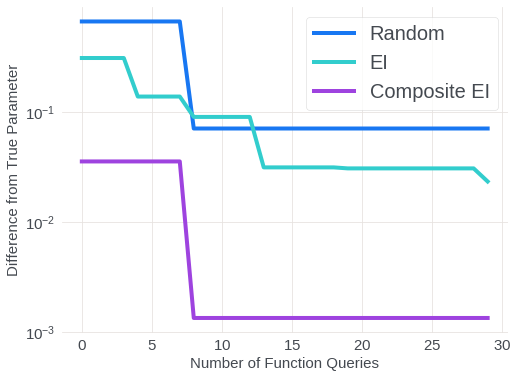

In [14]:
plt.figure(figsize=(8, 6))
labels_dict = {"rnd": "Random", "ei": "EI", "ei_hogp_cf": "Composite EI"}
for k in models_used:
    plt.plot(
        torch.arange(n_batches * batch_size),
        mean_results[k],
        label=labels_dict[k],
    )
plt.legend(fontsize=20)
plt.semilogy()
plt.xlabel("Number of Function Queries")
plt.ylabel("Difference from True Parameter")